## Calculate differences
- Calculate differences using different models on the effect of Trauma vs. Sad on amygdala (later hippocampus and vmPFC)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# regular GLMs
#import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
## Load amygdala database
df = pd.read_csv('amg_TraumavsNeutral.csv')
# create a long format for analysis
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['vmpfc1','vmpfc2','vmpfc3'])
df_long

,scr_id,groupIdx,variable,value
0,KPE008,1,vmpfc1,0.229618
1,KPE1223,1,vmpfc1,0.418279
2,KPE1253,0,vmpfc1,-0.087617
3,KPE1263,0,vmpfc1,-0.381604
4,KPE1293,1,vmpfc1,0.175758
...,...,...,...,...
76,KPE1561,0,vmpfc3,0.190942
77,KPE1573,1,vmpfc3,1.362443
78,KPE1578,0,vmpfc3,-0.438874
79,KPE1587,1,vmpfc3,NaN


In [4]:
## Start with simple GLM models (using statsmodel)
glm = smf.mixedlm('value ~ C(variable) * C(groupIdx)', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          value   
No. Observations:          75               Method:                      REML    
No. Groups:                27               Scale:                       0.2626  
Min. group size:           2                Log-Likelihood:              -60.3385
Max. group size:           3                Converged:                   Yes     
Mean group size:           2.8                                                   
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              -0.032    0.144 -0.223 0.823 -0.315  0.251
C(variable)[T.vmpfc2]                   0.111    0.205  0.542 0.588 -0.291  0.514
C(variable)[T.vmpfc3]                 

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [5]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.029      1     19  0.029  0.091    0.766  0.005  nan
variable     0.052      2     38  0.026  0.093    0.911  0.005    0.928
Interaction  0.033      2     38  0.016  0.059    0.942  0.003  nan



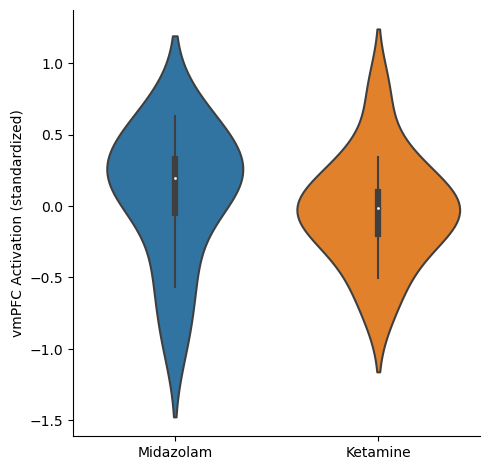

In [6]:
# simple boxplot graph
a = sns.catplot(y='vmpfc2', x='groupIdx', data= df, kind='violin')
a.set_xticklabels(labels = ["Midazolam", "Ketamine"])
a.set_xlabels("")
a.set_ylabels("vmPFC Activation (standardized)")
a.savefig('vmPFC__time2.png', dpi=300, bbox_inches='tight')

In [7]:
pg.ttest(df.vmpfc2[df.groupIdx==1], df.vmpfc2[df.groupIdx==0], 
         paired=False, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.645735,24,two-sided,0.524578,"[-0.44, 0.23]",0.254031,0.424,0.095105


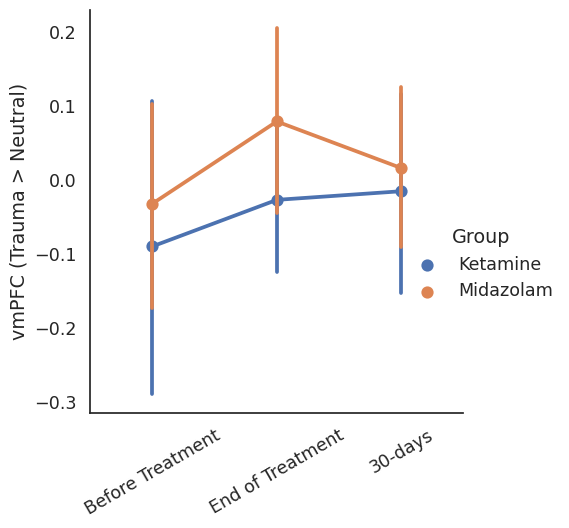

In [15]:
%matplotlib inline
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "End of Treatment", "30-days"], rotation=30)

g.set_ylabels("vmPFC (Trauma > Neutral)")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('vmPFC_pointGraph.png', dpi=300, bbox_inches='tight')

## Build a Bayesian model
- Here we would model each subject under each group

In [8]:
sns.catplot(y='value',x='variable', hue='groupIdx', kind = 'point', data=df_long, ci=68)

In [8]:
#df[['hippo1','hippo2','hippo3', 'hippo4','groupIdx']].groupby('groupIdx').describe()
df_long.groupby(['groupIdx','variable']).describe()

value                                                    \
                  count      mean       std       min       25%       50%   
groupIdx variable                                                           
0        vmpfc1    13.0 -0.032211  0.542301 -0.881910 -0.381604 -0.087617   
         vmpfc2    12.0  0.078617  0.460541 -0.914481 -0.046206  0.193359   
         vmpfc3    10.0  0.015832  0.341108 -0.438874 -0.269189 -0.011334   
1        vmpfc1    14.0 -0.089833  0.752698 -1.529759 -0.636457  0.021842   
         vmpfc2    14.0 -0.027090  0.374437 -0.718012 -0.193198 -0.015150   
         vmpfc3    12.0 -0.015453  0.483706 -0.374032 -0.314905 -0.191160   

                                       
                        75%       max  
groupIdx variable                      
0        vmpfc1    0.288639  0.879326  
         vmpfc2    0.330318  0.629830  
         vmpfc3    0.263908  0.624952  
1        vmpfc1    0.371114  1.284006  
         vmpfc2    0.097657  0.796530  
         vmpfc3    0.085462  1.362443

## Bayes Model

In [6]:
df_long2 = pd.melt(df, id_vars=['scr_id','groupIdx', 'vmpfc1'], value_vars=['vmpfc2','vmpfc3'])
df_long2

,scr_id,groupIdx,vmpfc1,variable,value
0,KPE008,1,0.229618,vmpfc2,0.055739
1,KPE1223,1,0.418279,vmpfc2,0.339514
2,KPE1253,0,-0.087617,vmpfc2,0.163191
3,KPE1263,0,-0.381604,vmpfc2,0.212869
4,KPE1293,1,0.175758,vmpfc2,-0.203011
5,KPE1307,1,-1.529759,vmpfc2,-0.718012
6,KPE1315,1,-0.757637,vmpfc2,0.036368
7,KPE1322,1,1.284006,vmpfc2,0.796530
8,KPE1339,1,-0.272918,vmpfc2,0.002748
9,KPE1343,1,-0.971054,vmpfc2,-0.087525


In [7]:
# take indexes for building the model
df_long2['scr_id'] = df_long2.scr_id.astype('category')
sub_idx = df_long2.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long2.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long2.variable = pd.Categorical(df_long2.variable, 
                    categories=['vmpfc2','vmpfc3'])
timeIDX = df_long2.variable.cat.codes.values
print(timeIDX)
df_long2['time'] = timeIDX

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26]
27
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [8]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sigma=0.1, shape=n_subs)
    cov = pm.Normal('cov', mu=0.05, sigma=0.1)
    b = pm.Normal('b', mu=0, sigma=0.1, shape=2)
    
    
   # bMed = pm.Normal('bMed', mu=0, sd=0.1, shape=2) #
   # sigma = pm.HalfCauchy('sigma', 1)
    interact = pm.Normal('interaction', mu=0, sigma=1, shape=(2,2))
  
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX] + interact[timeIDX,df_long2.groupIdx] + cov*df_long2.vmpfc1

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long2.value)
    
    
    # calculate differences and effect size
    diff_of_means1 = pm.Deterministic('differenceGroups end of treatment', interact[0,1] - interact[0,0])
    diff_of_means2 = pm.Deterministic('differenceGroups 30 days', interact[1,1] - interact[1,0])
   
    # effect size
    effect_size1 = pm.Deterministic('effect size2_1', 
                        diff_of_means1 / eps)
    
    effect_size2 = pm.Deterministic('effect size3_1', 
                        diff_of_means2 / eps)
    
#     effect_size3 = pm.Deterministic('effect size4_1', 
#                         abs(diff_of_means3) / eps)
    
    ppChecks = pm.sample_prior_predictive(samples = 8000)
    trace = pm.sample(draws=10000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=4)

/gpfs/ysm/project/joormann/oad4/conda_envs/pymc4/lib/python3.9/site-packages/pymc/model.py:1438: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, cov, b, interaction, eps, likelihood_missing]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 89 seconds.


In [13]:
az.summary(trace, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.008,0.095,-0.179,0.191,0.000,0.000,60599.0,31599.0,1.0
a[1],-0.001,0.095,-0.189,0.185,0.000,0.001,61947.0,29012.0,1.0
a[2],0.005,0.097,-0.187,0.193,0.000,0.001,59222.0,31483.0,1.0
a[3],0.009,0.095,-0.174,0.196,0.000,0.001,57209.0,28773.0,1.0
a[4],-0.026,0.094,-0.218,0.154,0.000,0.000,58362.0,31337.0,1.0
a[5],-0.014,0.097,-0.200,0.178,0.000,0.001,58589.0,30820.0,1.0
a[6],0.005,0.097,-0.187,0.194,0.000,0.001,61848.0,30134.0,1.0
a[7],0.042,0.096,-0.145,0.232,0.000,0.000,59004.0,29869.0,1.0
a[8],0.005,0.095,-0.182,0.190,0.000,0.001,57377.0,29832.0,1.0
a[9],-0.011,0.095,-0.192,0.183,0.000,0.001,58198.0,29502.0,1.0


({'BF10': array([0.46788761]), 'BF01': array([2.13726538])},
 <Axes: title={'center': 'The BF_10 is 0.47\nThe BF_01 is 2.14'}, xlabel='effect size2_1', ylabel='Density'>)

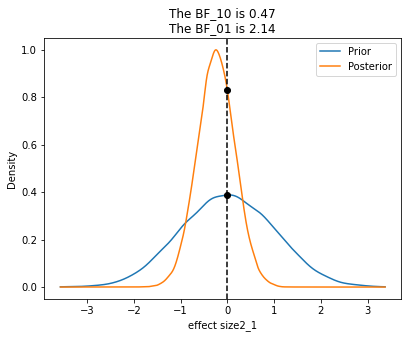

In [9]:
az.plot_bf(trace, var_name = 'effect size2_1', prior = np.random.normal(0, 1, 5000))

({'BF10': array([0.43227953]), 'BF01': array([2.31331793])},
 <Axes: title={'center': 'The BF_10 is 0.43\nThe BF_01 is 2.31'}, xlabel='effect size3_1', ylabel='Density'>)

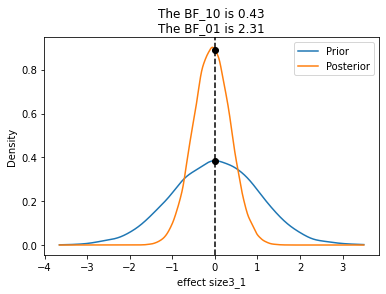

In [10]:
az.plot_bf(trace, var_name = 'effect size3_1', prior = np.random.normal(0, 1, 5000))

In [15]:
# assess difference HDI
print(f'Mean {np.mean(diffTime.ravel())}')
print(f'SD {np.std(diffTime.ravel())}')
pm.stats.hdi(diffTime.ravel(), hdi_prob=.9)

Mean 0.023587168454135516
SD 0.12396036010604798


array([-0.18308098,  0.22451937])

## Next we calculate the difference between the groups in each time
- Althgough the interaction wasn't significant, we still look at this one - as there's a group difference

In [16]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('vmpfc1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.027,0.201,-0.373,0.278,0.005,0.003,1804.0,2077.0,1.0
groupIdx,-0.063,0.277,-0.504,0.404,0.006,0.005,1839.0,2085.0,1.0
sd,0.696,0.106,0.519,0.851,0.002,0.002,1791.0,1642.0,1.0


In [17]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('vmpfc2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.077,0.127,-0.124,0.287,0.003,0.002,1789.0,1922.0,1.0
groupIdx,-0.105,0.175,-0.397,0.184,0.004,0.003,1700.0,2105.0,1.0
sd,0.438,0.071,0.329,0.553,0.002,0.001,1587.0,1175.0,1.0


In [18]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('vmpfc3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.021,0.153,-0.221,0.276,0.004,0.003,1689.0,1798.0,1.0
groupIdx,-0.038,0.208,-0.384,0.279,0.005,0.004,1660.0,1875.0,1.0
sd,0.458,0.081,0.335,0.584,0.002,0.001,1969.0,1997.0,1.0


In [19]:
## create a function that will simply run the model for each session
def runModel(variable):
    with pm.Model() as hierarchical:
      
        a = pm.Normal('a', mu=0, sd=1) 
        bMed = pm.Normal('bMed', mu=0, sd=1, shape=2) #

        # Model error
        eps = pm.HalfCauchy('eps', 5)

        y_hat = a + bMed[df.groupIdx]

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=df[str(variable)])

        trace = pm.sample(draws=2000, tune=2000,target_accept=0.9, return_inferencedata=False, cores=4)
        diff = trace['bMed'][:,1] - trace['bMed'][:,0]
    return trace, diff

In [20]:
ses1trace, ses1Diff = runModel('vmpfc1')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, bMed, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.


Group difference is 0.411375


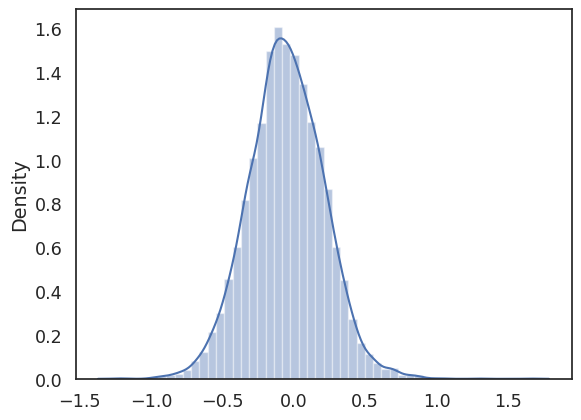

In [21]:
pm.summary(ses1trace)
sns.distplot(ses1Diff)
print(f'Group difference is {sum(ses1Diff>0)/len(ses1Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


Group difference is 0.270875


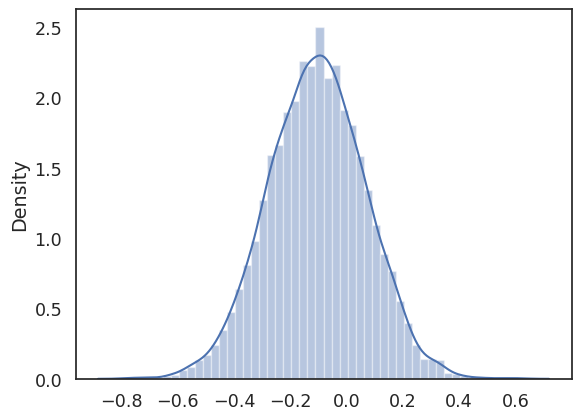

In [22]:
ses2trace, ses2Diff = runModel('vmpfc2')
pm.summary(ses2trace)
sns.distplot(ses2Diff)
print(f'Group difference is {sum(ses2Diff>0)/len(ses2Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


Group difference is 0.437625


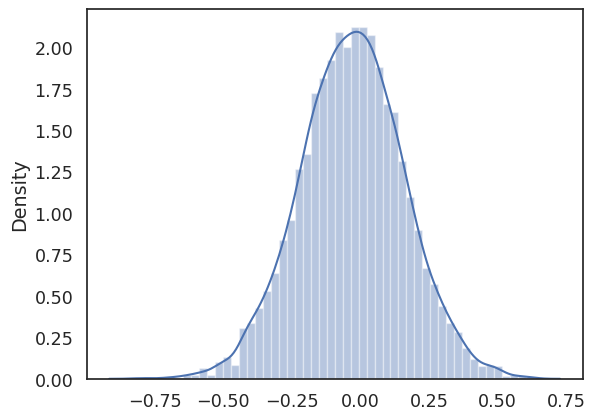

In [23]:
ses3trace, ses3Diff = runModel('vmpfc3')
pm.summary(ses3trace)
sns.distplot(ses3Diff)
print(f'Group difference is {sum(ses3Diff>0)/len(ses3Diff)}')

## Plotting like We did in amygdala and hippocampus

In [26]:
# set variables
def plotDiff(depVar,indepVar, trace):
    sns.set_style("ticks") # set style
    y = str(depVar)
    dfPlot = df
    ci = np.quantile(trace.posterior[str(indepVar)], [.05,.95])
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(3, 5),gridspec_kw={'width_ratios': [1, .2],
                                                            'wspace':.1})
    g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
    sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
                boxprops=dict(alpha=.3))
    g2 = sns.distplot(trace.posterior[str(indepVar)], ax = ax2, vertical=True)
    ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
               linewidth = 3, linestyle = "-")

    #g3.set_ylim(-.7, .7)
    #ax1.set_ylim(-.7,.7)
    ax2.set_ylim(-0.8, 1)#(g1.get_ylim()) # use first graph's limits to get the relevant for this one
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax2.set_ylabel("Difference between groups", fontsize=14) 
    ax2.yaxis.set_label_position("right")
    ax1.set_ylabel("vmPFC reactivity to traumatic script", fontsize=12)
   # ax1.set_xlabel("Group", fontsize=14)
    fig.savefig( str(depVar) + 'Reactivity.png', dpi=300, bbox_inches='tight')
    return fig

In [27]:
def plotSubfigs(subfigs,subNum, depVar,indepVar, trace, title):
    # gets subfig and the index number of it to plot the same as above
    sns.set_style("ticks") # set style
    y = str(depVar)
    dfPlot = df
    ci = np.quantile(trace.posterior[str(indepVar)], [.025,.975])
    axsLeft = subfigs[subNum].subplots(1,2, gridspec_kw={'width_ratios': [1, .2],'wspace':.01})
    ax1 = axsLeft[0]
    ax2 = axsLeft[1]
    g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
    sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
                 boxprops=dict(alpha=.3))
    g2 = sns.distplot(trace.posterior[str(indepVar)], ax = ax2, vertical=True)
    ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
                linewidth = 3, linestyle = "-")

    ax2.set_ylim(-0.8, 1)#(g1.get_ylim()) # use first graph's limits to get the relevant for this one
    ax1.set_ylim(-0.8, 1)
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax2.set_ylabel("Difference between groups", fontsize=14) 
    ax2.yaxis.set_label_position("right")
    ax1.set_ylabel("vmPFC reactivity to traumatic script", fontsize=12)
    ax1.set_xlabel('')#("Group", fontsize=14)
    ax1.set_title(title, fontsize=15)
    #ax1.title.set_style(font="large")

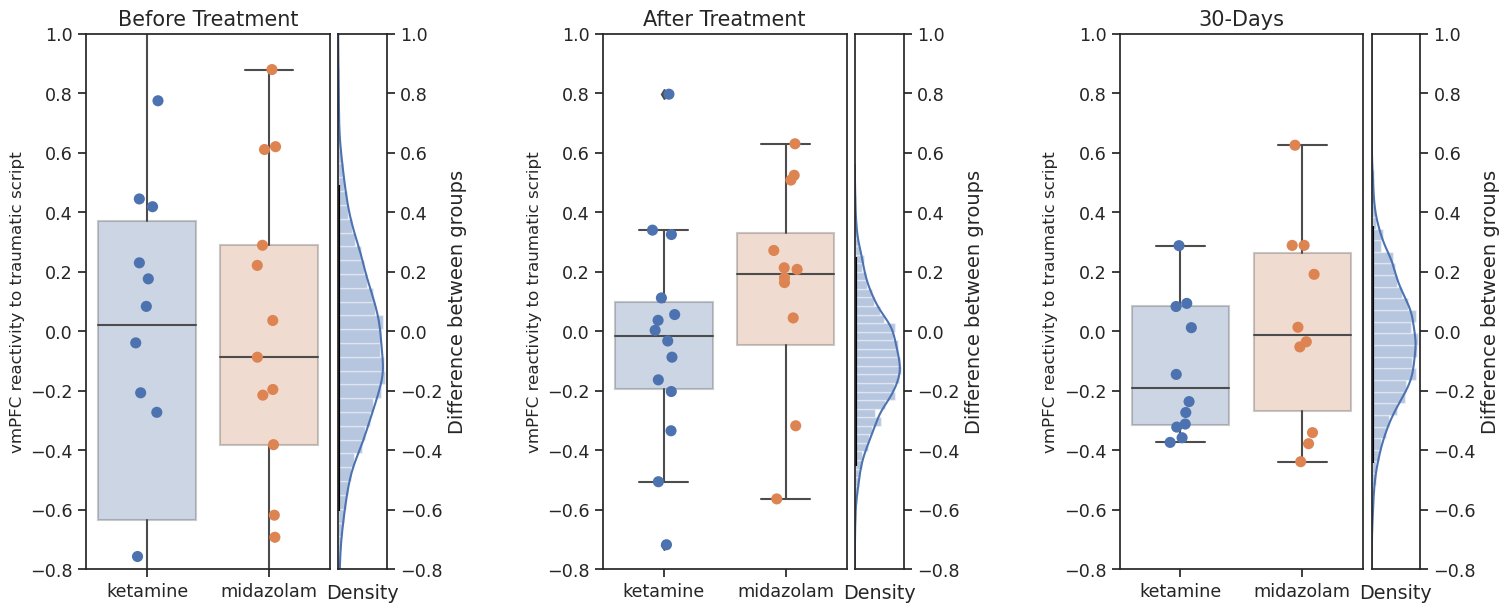

In [28]:
fig = plt.figure(constrained_layout=True, figsize=(15, 6))
subfigs = fig.subfigures(1, 3, wspace=0.1)
plotSubfigs(subfigs, 0, 'vmpfc1','groupIdx',traceSes1, "Before Treatment")
#subfigs[0].suptitle('Before Treatment', fontsize='large')
plotSubfigs(subfigs, 1, 'vmpfc2','groupIdx',traceSes2, 'After Treatment')
#subfigs[1].suptitle('After Treatment', fontsize='large')
plotSubfigs(subfigs, 2,'vmpfc3','groupIdx',traceSes3, '30-Days')
#subfigs[2].suptitle('Follow-Up', fontsize='large')
fig.savefig("vmPFC_reactivity.png",  dpi=300, bbox_inches='tight')